In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import pathlib

from datetime import datetime, time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from ipywidgets import IntProgress
from IPython.display import display
import time


In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [4]:
max_count_progress = 100

In [5]:
BASE_DIR = pathlib.Path().cwd()

In [6]:
df = pd.read_csv('base_table.csv', parse_dates= ['call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime'])

In [7]:
def show_progress(current, total, bar_length=50):
    progress = current / total
    block = int(bar_length * progress)
    bar = '█' * block + '-' * (bar_length - block)
    progress_percent = progress * 100
    print(f'\rProgress: [{bar}] {progress_percent:.2f}% ({current}/{total})', end='')
    

In [8]:
sentires = BASE_DIR / 'sentiment_analysis_results.csv'
if not sentires.exists():
        
    sia = SentimentIntensityAnalyzer()
    
    print("Starting sentiment analysis on call transcripts...")
    
    total_transcripts = len(df)
    
    sentiment_scores = []
    
    for idx, transcript in enumerate(df['call_transcript']):
        score = sia.polarity_scores(str(transcript))
        sentiment_scores.append(score)
        
        show_progress(idx + 1, total_transcripts)
    
    df['sentiment_scores'] = sentiment_scores
    
    df['compound_sentiment'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
    
    def label_sentiment(compound_score):
        if compound_score >= 0.05:
            return 'Positive'
        elif compound_score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    
    df['sentiment_label'] = df['compound_sentiment'].apply(label_sentiment)
    
    print("\nSentiment analysis complete! Saving results to a CSV file...")
    
    output_filename = 'sentiment_analysis_results.csv'
    df[['call_id', 'sentiment_label', 'sentiment_scores', 'compound_sentiment']].to_csv(output_filename, index=False)
    
    print(f"Results saved successfully to {output_filename}!")
    print("Here are the first few rows of the analysis:\n")
else:
    sentirespd = pd.read_csv(sentires)
    df = df.merge(sentirespd[['call_id', 'sentiment_label', 'sentiment_scores', 'compound_sentiment']], on= 'call_id', how= 'left')
    print("got everything")



Starting sentiment analysis on call transcripts...
Progress: [██████████████████████████████████████████████████] 100.00% (71810/71810)
Sentiment analysis complete! Saving results to a CSV file...
Results saved successfully to sentiment_analysis_results.csv!
Here are the first few rows of the analysis:



In [9]:
df[['call_transcript', 'sentiment_scores', 'compound_sentiment', 'sentiment_label']].head()

,call_transcript,sentiment_scores,compound_sentiment,sentiment_label
0,\n\nAgent: Thank you for calling United Airlin...,"{'neg': 0.026, 'neu': 0.808, 'pos': 0.167, 'co...",0.9982,Positive
1,\n\nAgent: Thank you for calling United Airlin...,"{'neg': 0.091, 'neu': 0.72, 'pos': 0.189, 'com...",0.9974,Positive
2,\n\nAgent: Thank you for calling United Airlin...,"{'neg': 0.117, 'neu': 0.67, 'pos': 0.213, 'com...",0.9977,Positive
3,\n\nAgent: Thank you for calling United Airlin...,"{'neg': 0.024, 'neu': 0.773, 'pos': 0.202, 'co...",0.9979,Positive
4,\n\nAgent: Thank you for calling United Airlin...,"{'neg': 0.101, 'neu': 0.75, 'pos': 0.149, 'com...",0.9832,Positive


In [10]:
sentiment_counts = df['sentiment_label'].value_counts()

sentiment_counts

sentiment_label
Positive    71299
Negative      511
Name: count, dtype: int64

In [11]:
all_words = []

def preprocess_transcript(transcript):
    transcript = transcript.lower()
    transcript = transcript.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(transcript)
    return tokens

total_transcripts = len(df['call_transcript'])
for i, transcript in enumerate(df['call_transcript']):
    tokens = preprocess_transcript(transcript)
    all_words.extend(tokens)
    
    progress_percentage = (i + 1) / total_transcripts * 100
    print(f'\rProcessing Transcripts: {progress_percentage:.2f}% complete', end='')

total_words = len(all_words)

stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stop_words]

word_freq = nltk.FreqDist(filtered_words)

print(f'Total number of words in all transcripts: {total_words}')
print(f'Word frequency count:\n{word_freq.most_common(100)}')  # Display the 10 most common words

Processing Transcripts: 100.00% completeTotal number of words in all transcripts: 35951751
Word frequency count:
[('flight', 629838), ('agent', 554444), ('customer', 545636), ('let', 301864), ('change', 245470), ('im', 237889), ('help', 200997), ('like', 194031), ('thank', 184714), ('would', 176120), ('united', 171993), ('calling', 159962), ('get', 156275), ('typing', 145689), ('next', 142014), ('okay', 138219), ('work', 134041), ('day', 132394), ('take', 131403), ('youre', 128607), ('need', 126264), ('yeah', 122941), ('really', 119975), ('time', 119508), ('thanks', 119487), ('know', 118796), ('chicago', 115015), ('one', 114165), ('call', 113217), ('looks', 112484), ('please', 107511), ('today', 106985), ('look', 106961), ('could', 102295), ('see', 100099), ('fee', 97703), ('reservation', 97645), ('make', 96256), ('travel', 94347), ('good', 93838), ('booked', 92608), ('new', 90384), ('name', 89990), ('airlines', 89222), ('anything', 86991), ('check', 85308), ('understand', 83499), ('pr

In [12]:
unique_words_count = len(word_freq)
print(f'Total number of unique words (excluding stop words): {unique_words_count}')

Total number of unique words (excluding stop words): 51083


In [13]:
all_words = []
negative_keywords = ['unhappy', 'frustrated', 'unacceptable', 'angry', 'urgent', 'critical', 'still not resolved']
negative_word_counts = {keyword: 0 for keyword in negative_keywords} 

def preprocess_transcript(transcript):
    transcript = transcript.lower()
    transcript = transcript.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(transcript)
    return tokens

total_transcripts = len(df['call_transcript'])
for i, transcript in enumerate(df['call_transcript']):
    tokens = preprocess_transcript(transcript)
    all_words.extend(tokens)

    for keyword in negative_keywords:
        negative_word_counts[keyword] += tokens.count(keyword)

    progress_percentage = (i + 1) / total_transcripts * 100
    print(f'\rProcessing Transcripts: {progress_percentage:.2f}% complete', end='')

print(f'\nNegative word frequency counts:')
for keyword, count in negative_word_counts.items():
    print(f'{keyword}: {count}')

Processing Transcripts: 100.00% complete
Negative word frequency counts:
unhappy: 562
frustrated: 9484
unacceptable: 13459
angry: 4647
urgent: 54
critical: 50
still not resolved: 0


In [14]:
negative_keywords = ['unhappy', 'frustrated', 'unacceptable', 'angry', 'urgent', 'critical', 'still not resolved', 'same problem']
negative_word_counts = {keyword: 0 for keyword in negative_keywords}  
negative_records = []

total_transcripts = len(df['call_transcript'])
for i, row in df.iterrows():
    customer_id = row['customer_id']
    transcript = row['call_transcript']
    call_id = row['call_id']
    agent_id = row['agent_id']
    call_start_datetime = row['call_start_datetime']
    agent_assigned_datetime = row['agent_assigned_datetime']
    call_end_datetime = row['call_end_datetime']
    call_transcript = row['call_transcript']
    customer_name = row['customer_name']
    elite_level_code = row['elite_level_code']
    primary_call_reason = row['primary_call_reason']
    agent_tone = row['agent_tone']
    customer_tone = row['customer_tone']
    average_sentiment = row['average_sentiment']
    silence_percent_average = row['silence_percent_average']
    handle_time = row['handle_time']
    speed_to_answer = row['speed_to_answer']

    tokens = preprocess_transcript(transcript)
    all_words.extend(tokens)

    found_negative = False
    for keyword in negative_keywords:
        if keyword in tokens:
            negative_word_counts[keyword] += tokens.count(keyword)
            found_negative = True 

    if found_negative:
        negative_records.append({
            'customer_id': customer_id,
            'transcript': transcript,
            'call_id': call_id,
            'agent_id': agent_id,
            'call_start_datetime': call_start_datetime,
            'agent_assigned_datetime': agent_assigned_datetime,
            'call_end_datetime': call_end_datetime,
            'call_transcript': call_transcript,
            'customer_name': customer_name,
            'elite_level_code': elite_level_code,
            'primary_call_reason': primary_call_reason,
            'agent_tone': agent_tone,
            'customer_tone': customer_tone,
            'average_sentiment': average_sentiment,
            'silence_percent_average': silence_percent_average,
            'handle_time': handle_time,
            'speed_to_answer': speed_to_answer
        })

    progress_percentage = (i + 1) / total_transcripts * 100
    print(f'\rProcessing Transcripts: {progress_percentage:.2f}% complete', end='')

negative_df = pd.DataFrame(negative_records)

Processing Transcripts: 100.00% complete

In [15]:
print(f'\nNegative word frequency counts:')
for keyword, count in negative_word_counts.items():
    print(f'{keyword}: {count}')

print('\nDataFrame with spam-related calls:')
negative_df


Negative word frequency counts:
unhappy: 562
frustrated: 9484
unacceptable: 13459
angry: 4647
urgent: 54
critical: 50
still not resolved: 0
same problem: 0

DataFrame with spam-related calls:


,customer_id,transcript,call_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,handle_time,speed_to_answer
0,8994245383,\n\nAgent: Thank you for calling United Airlin...,325527,607742,2024-08-18 07:41:00,2024-08-18 07:45:00,2024-08-18 07:50:00,\n\nAgent: Thank you for calling United Airlin...,Andrew Hess,-1.0,IRROPS,0.0,1,-0.19,0.05,540.0,240.0
1,5769982111,\n\nAgent: Thank you for calling United Airlin...,526871,748700,2024-08-10 11:59:00,2024-08-10 12:08:00,2024-08-10 12:15:00,\n\nAgent: Thank you for calling United Airlin...,Joseph Thomas,3.0,Voluntary Change,0.0,2,-0.22,0.13,960.0,540.0
2,7388532911,\n\nAgent: Thank you for calling United Airlin...,1228137,153460,2024-08-20 10:25:00,2024-08-20 10:31:00,2024-08-20 10:45:00,\n\nAgent: Thank you for calling United Airlin...,Cynthia Smith,1.0,Upgrade,0.0,2,0.00,0.43,1200.0,360.0
3,6000487174,\n\nAgent: Thank you for calling United Airlin...,1770187,819946,2024-08-17 09:38:00,2024-08-17 09:44:00,2024-08-17 09:53:00,\n\nAgent: Thank you for calling United Airlin...,Michael Kim,0.0,IRROPS,0.0,2,-0.08,0.11,900.0,360.0
4,6665161812,\n\nAgent: Thank you for calling United Airlin...,1829764,266966,2024-08-31 01:32:00,2024-08-31 01:40:00,2024-08-31 02:03:00,\n\nAgent: Thank you for calling United Airlin...,Dawn Cooper,-1.0,IRROPS,0.0,1,-0.13,0.28,1860.0,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18323,1506820076,\n\nAgent: Thank you for calling United custom...,9999083188,668841,2024-08-18 15:28:00,2024-08-18 15:38:00,2024-08-18 15:51:00,\n\nAgent: Thank you for calling United custom...,Justin Johnson,-1.0,Post-Flight,0.0,1,-0.02,0.40,1380.0,600.0
18324,2622245892,\n\nAgent: Thank you for calling United Airlin...,9999181916,910145,2024-08-04 10:35:00,2024-08-04 10:40:00,2024-08-04 10:43:00,\n\nAgent: Thank you for calling United Airlin...,James Booth,1.0,Products and Services,2.0,1,-0.27,0.09,480.0,300.0
18325,768923371,\n\nAgent: Thank you for calling United Airlin...,9999335958,828869,2024-08-03 02:30:00,2024-08-03 02:36:00,2024-08-03 02:40:00,\n\nAgent: Thank you for calling United Airlin...,Ryan Shaw,1.0,IRROPS,-1.0,1,0.14,0.15,600.0,360.0
18326,3173856584,\n\nAgent: Thank you for calling United Airlin...,9999669038,819946,2024-08-19 12:50:00,2024-08-19 12:55:00,2024-08-19 13:35:00,\n\nAgent: Thank you for calling United Airlin...,Marvin White,3.0,Mileage Plus,-1.0,1,0.07,0.52,2700.0,300.0


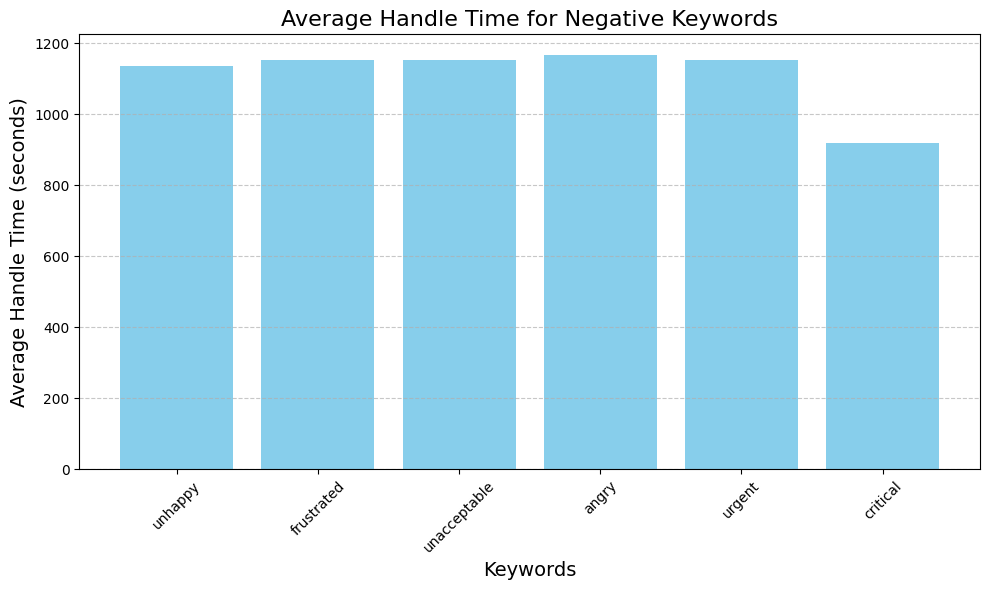

In [16]:
negative_keywords = ['unhappy', 'frustrated', 'unacceptable', 'angry', 'urgent', 'critical']

average_handle_times_n = {}

for keyword in negative_keywords:
    filtered_df = df[df['call_transcript'].str.contains(keyword, case=False, na=False)]
    average_handle_time_n = filtered_df['handle_time'].mean()
    average_handle_times_n[keyword] = average_handle_time_n

average_handle_time_n_df = pd.DataFrame(list(average_handle_times_n.items()), columns=['Keyword', 'Average Handle Time'])

plt.figure(figsize=(10, 6))
plt.bar(average_handle_time_n_df['Keyword'], average_handle_time_n_df['Average Handle Time'], color='skyblue')
plt.title('Average Handle Time for Negative Keywords', fontsize=16)
plt.xlabel('Keywords', fontsize=14)
plt.ylabel('Average Handle Time (seconds)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [17]:
all_words = []
positive_keywords = ['happy', 'satisfied', 'great', 'excellent', 'appreciate', 'love', 'perfect']
positive_word_counts = {keyword: 0 for keyword in positive_keywords}  

def preprocess_transcript(transcript):
    transcript = transcript.lower()
    transcript = transcript.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(transcript)
    return tokens

total_transcripts = len(df['call_transcript'])
for i, transcript in enumerate(df['call_transcript']):
    tokens = preprocess_transcript(transcript)
    all_words.extend(tokens)

    for keyword in positive_keywords:
        positive_word_counts[keyword] += tokens.count(keyword)

    progress_percentage = (i + 1) / total_transcripts * 100
    print(f'\rProcessing Transcripts: {progress_percentage:.2f}% complete', end='')

print(f'\nPositive word frequency counts:')
for keyword, count in positive_word_counts.items():
    print(f'{keyword}: {count}')

Processing Transcripts: 100.00% complete
Positive word frequency counts:
happy: 42635
satisfied: 679
great: 41664
excellent: 442
appreciate: 62788
love: 317
perfect: 9104


In [18]:
positive_keywords = ['happy', 'satisfied', 'great', 'excellent', 'appreciate', 'love', 'perfect']
positive_word_counts = {keyword: 0 for keyword in positive_keywords}  
positive_records = []

total_transcripts = len(df['call_transcript'])
for i, row in df.iterrows():
    customer_id = row['customer_id']
    transcript = row['call_transcript']
    call_id = row['call_id']
    agent_id = row['agent_id']
    call_start_datetime = row['call_start_datetime']
    agent_assigned_datetime = row['agent_assigned_datetime']
    call_end_datetime = row['call_end_datetime']
    call_transcript = row['call_transcript']
    customer_name = row['customer_name']
    elite_level_code = row['elite_level_code']
    primary_call_reason = row['primary_call_reason']
    agent_tone = row['agent_tone']
    customer_tone = row['customer_tone']
    average_sentiment = row['average_sentiment']
    silence_percent_average = row['silence_percent_average']
    handle_time = row['handle_time']
    speed_to_answer = row['speed_to_answer']

    tokens = preprocess_transcript(transcript)
    all_words.extend(tokens)

    found_positive = False
    for keyword in positive_keywords:
        if keyword in tokens:
            positive_word_counts[keyword] += tokens.count(keyword)
            found_positive = True 

    if found_positive:
        positive_records.append({
            'customer_id': customer_id,
            'transcript': transcript,
            'call_id': call_id,
            'agent_id': agent_id,
            'call_start_datetime': call_start_datetime,
            'agent_assigned_datetime': agent_assigned_datetime,
            'call_end_datetime': call_end_datetime,
            'call_transcript': call_transcript,
            'customer_name': customer_name,
            'elite_level_code': elite_level_code,
            'primary_call_reason': primary_call_reason,
            'agent_tone': agent_tone,
            'customer_tone': customer_tone,
            'average_sentiment': average_sentiment,
            'silence_percent_average': silence_percent_average,
            'handle_time': handle_time,
            'speed_to_answer': speed_to_answer
        })

    progress_percentage = (i + 1) / total_transcripts * 100
    print(f'\rProcessing Transcripts: {progress_percentage:.2f}% complete', end='')

positive_df = pd.DataFrame(positive_records)

Processing Transcripts: 100.00% complete

In [19]:
print(f'\nPositive word frequency counts:')
for keyword, count in positive_word_counts.items():
    print(f'{keyword}: {count}')

print('\nDataFrame with spam-related calls:')
positive_df


Positive word frequency counts:
happy: 42635
satisfied: 679
great: 41664
excellent: 442
appreciate: 62788
love: 317
perfect: 9104

DataFrame with spam-related calls:


,customer_id,transcript,call_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,handle_time,speed_to_answer
0,103262588,\n\nAgent: Thank you for calling United Airlin...,131642,132311,2024-08-04 17:46:00,2024-08-04 17:55:00,2024-08-04 17:59:00,\n\nAgent: Thank you for calling United Airlin...,Michael Petersen,0.0,Seating,0.0,-2,-0.07,0.03,780.0,540.0
1,5769982111,\n\nAgent: Thank you for calling United Airlin...,526871,748700,2024-08-10 11:59:00,2024-08-10 12:08:00,2024-08-10 12:15:00,\n\nAgent: Thank you for calling United Airlin...,Joseph Thomas,3.0,Voluntary Change,0.0,2,-0.22,0.13,960.0,540.0
2,9534089270,\n\nAgent: Thank you for calling United Airlin...,634548,542034,2024-08-11 11:15:00,2024-08-11 11:25:00,2024-08-11 11:39:00,\n\nAgent: Thank you for calling United Airlin...,Victoria Green,0.0,Seating,0.0,-2,-0.11,0.24,1440.0,600.0
3,3046806067,\n\nAgent: Thank you for calling United Airlin...,693921,633922,2024-08-06 15:58:00,2024-08-06 16:09:00,2024-08-06 16:15:00,\n\nAgent: Thank you for calling United Airlin...,Vickie Lopez,1.0,Voluntary Change,0.0,2,-0.02,0.14,1020.0,660.0
4,8760640596,\n\nAgent: Thank you for calling United Airlin...,723257,717526,2024-08-10 16:21:00,2024-08-10 16:29:00,2024-08-10 16:55:00,\n\nAgent: Thank you for calling United Airlin...,Ryan Mccoy,2.0,Mileage Plus,0.0,0,-0.09,0.42,2040.0,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60998,3020619605,\n\nAgent: Thank you for calling United Airlin...,9999336076,309976,2024-08-19 21:04:00,2024-08-19 21:16:00,2024-08-19 21:26:00,\n\nAgent: Thank you for calling United Airlin...,Jared Schultz,1.0,Traveler Updates,-1.0,-1,0.03,0.49,1320.0,720.0
60999,915905859,\n\nAgent: Thank you for calling United Airlin...,9999337789,418648,2024-08-21 23:08:00,2024-08-21 23:17:00,2024-08-21 23:24:00,\n\nAgent: Thank you for calling United Airlin...,Jose Black,-1.0,NaN,0.0,0,-0.05,0.15,960.0,540.0
61000,3888680689,\n\nAgent: Thank you for calling United Airlin...,9999524523,901589,2024-08-20 17:30:00,2024-08-20 17:36:00,2024-08-20 17:39:00,\n\nAgent: Thank you for calling United Airlin...,Angela Johnson,1.0,IRROPS,0.0,-1,-0.05,0.21,540.0,360.0
61001,4101455140,\n\nAgent: Thank you for calling United Airlin...,9999623753,835105,2024-08-03 14:07:00,2024-08-03 14:11:00,2024-08-03 14:28:00,\n\nAgent: Thank you for calling United Airlin...,Michael Reed,-1.0,IRROPS,0.0,0,-0.17,0.40,1260.0,240.0


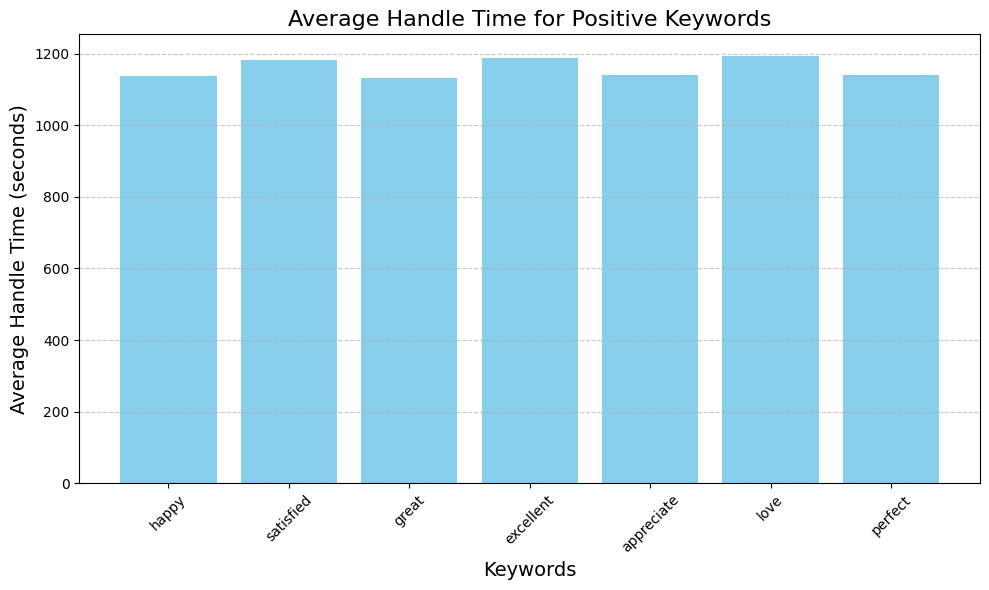

In [20]:
positive_keywords = ['happy', 'satisfied', 'great', 'excellent', 'appreciate', 'love', 'perfect']

average_handle_times = {}

for keyword in positive_keywords:
    filtered_df = df[df['call_transcript'].str.contains(keyword, case=False, na=False)]
    average_handle_time = filtered_df['handle_time'].mean()
    average_handle_times[keyword] = average_handle_time

average_handle_time_df = pd.DataFrame(list(average_handle_times.items()), columns=['Keyword', 'Average Handle Time'])

plt.figure(figsize=(10, 6))
plt.bar(average_handle_time_df['Keyword'], average_handle_time_df['Average Handle Time'], color='skyblue')
plt.title('Average Handle Time for Positive Keywords', fontsize=16)
plt.xlabel('Keywords', fontsize=14)
plt.ylabel('Average Handle Time (seconds)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

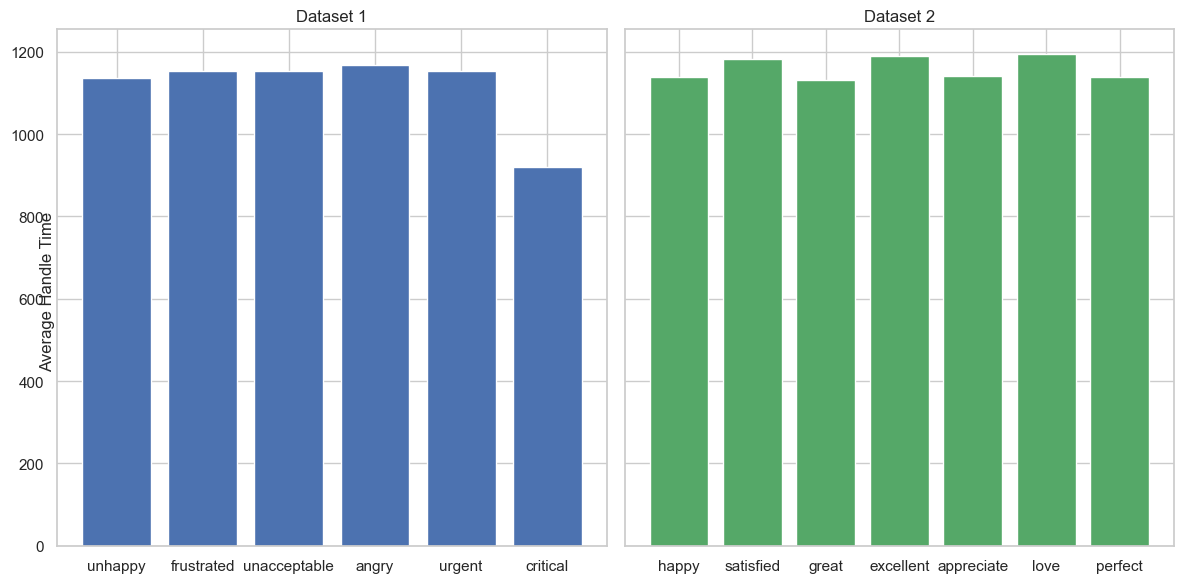

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax1.bar(average_handle_time_n_df['Keyword'], average_handle_time_n_df['Average Handle Time'], color='b')
ax1.set_title('Dataset 1')

ax2.bar(average_handle_time_df['Keyword'], average_handle_time_df['Average Handle Time'], color='g')
ax2.set_title('Dataset 2')

fig.text(0.04, 0.5, 'Average Handle Time', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

# Inference from the Positive vs Negative Keyword Analysis
- It is clear that in Positive case, ie, when the problems are being solved,<br>
    the AHT is high, ie, the agents have to put in more time, resources, efforts to achieve a positive sentiment
- To minimize the AHT, the agents must be properly trained to solve it in a timely manner
- Having done that, the positive bars start appearing early, and therefore, the customer leaves happily while the AHT is minimized

In [33]:
df['call_start_datetime'] = pd.to_datetime(df['call_start_datetime'])

df['hour_of_day'] = df['call_start_datetime'].dt.hour

def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

time_of_day_duration = {
    'Morning': '5 AM - 12 PM',
    'Afternoon': '12 PM - 5 PM',
    'Evening': '5 PM - 9 PM',
    'Night': '9 PM - 5 AM'
}

df['time_of_day'] = df['hour_of_day'].apply(categorize_time_of_day)

time_of_day_stats = df.groupby('time_of_day').agg(
    total_calls=('call_id', 'count'),
    average_handle_time=('handle_time', 'mean'),
    average_speed_to_answer=('speed_to_answer', 'mean')
).reset_index()

time_of_day_stats['time_duration'] = time_of_day_stats['time_of_day'].map(time_of_day_duration)

time_of_day_stats = time_of_day_stats.sort_values(by='total_calls', ascending=False)

time_of_day_stats[['time_of_day', 'time_duration', 'total_calls', 'average_handle_time', 'average_speed_to_answer']]


,time_of_day,time_duration,total_calls,average_handle_time,average_speed_to_answer
0,Afternoon,12 PM - 5 PM,26083,1129.648430,436.564812
2,Morning,5 AM - 12 PM,24761,1136.382214,438.476637
1,Evening,5 PM - 9 PM,12161,1137.498561,437.199243
3,Night,9 PM - 5 AM,8805,1136.306644,434.412266


In [36]:
time_of_day_stats.iloc[[0, 1]] = time_of_day_stats.iloc[[1, 0]]

In [37]:
time_of_day_stats

,time_of_day,total_calls,average_handle_time,average_speed_to_answer,time_duration
0,Morning,24761,1136.382214,438.476637,5 AM - 12 PM
2,Afternoon,26083,1129.648430,436.564812,12 PM - 5 PM
1,Evening,12161,1137.498561,437.199243,5 PM - 9 PM
3,Night,8805,1136.306644,434.412266,9 PM - 5 AM


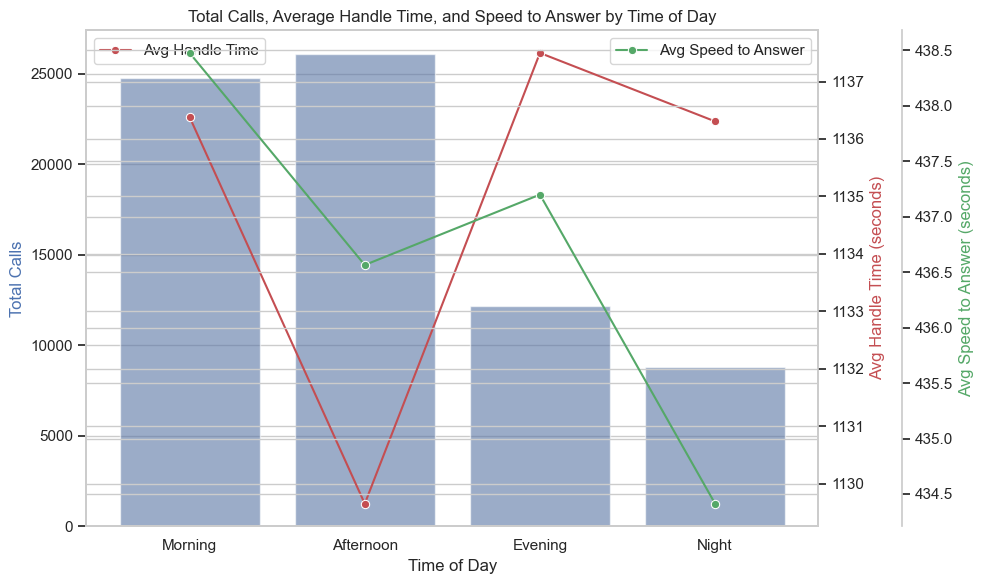

In [38]:
sns.set(style='whitegrid')

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x='time_of_day', y='total_calls', data=time_of_day_stats, ax=ax1, color='b', alpha=0.6)
ax1.set_ylabel('Total Calls', color='b')
ax1.set_xlabel('Time of Day')
ax1.set_title('Total Calls, Average Handle Time, and Speed to Answer by Time of Day')

ax2 = ax1.twinx()
sns.lineplot(x='time_of_day', y='average_handle_time', data=time_of_day_stats, ax=ax2, color='r', label='Avg Handle Time', marker='o')
ax2.set_ylabel('Avg Handle Time (seconds)', color='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60)) 
sns.lineplot(x='time_of_day', y='average_speed_to_answer', data=time_of_day_stats, ax=ax3, color='g', label='Avg Speed to Answer', marker='o')
ax3.set_ylabel('Avg Speed to Answer (seconds)', color='g')

ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Inference from the Call density vs AHT and AST is plotted
- We have significantly high handle time in morning even though the most number of calls are in the afternoon
- We can allocate the resources like agents accordingly to handle the number of calls in morning and afternoon
- Properly seeing the reason we can suggest that the agents get screened before they get picked   

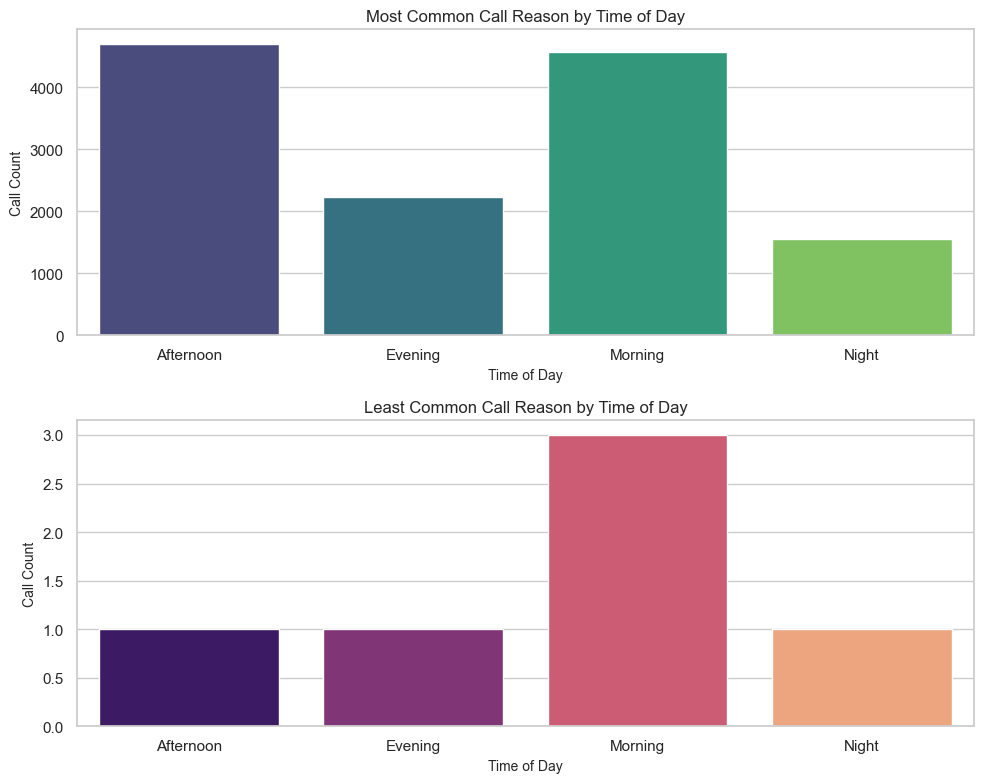

In [24]:
reason_by_time = df.groupby(['time_of_day', 'primary_call_reason']).size().reset_index(name='call_count')

most_common_reasons = reason_by_time.loc[reason_by_time.groupby('time_of_day')['call_count'].idxmax()]
least_common_reasons = reason_by_time.loc[reason_by_time.groupby('time_of_day')['call_count'].idxmin()]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

sns.barplot(x='time_of_day', y='call_count', data=most_common_reasons, palette="viridis", ax=axes[0], hue='time_of_day', legend=False)
axes[0].set_title('Most Common Call Reason by Time of Day', fontsize=12)
axes[0].set_xlabel('Time of Day', fontsize=10)
axes[0].set_ylabel('Call Count', fontsize=10)

sns.barplot(x='time_of_day', y='call_count', data=least_common_reasons, palette="magma", ax=axes[1], hue='time_of_day', legend=False)
axes[1].set_title('Least Common Call Reason by Time of Day', fontsize=12)
axes[1].set_xlabel('Time of Day', fontsize=10)
axes[1].set_ylabel('Call Count', fontsize=10)

plt.tight_layout()  
plt.show()

In [25]:
print("\nMost Common Call Reasons by Time of Day:")
most_common_reasons[['time_of_day', 'primary_call_reason', 'call_count']]


Most Common Call Reasons by Time of Day:


,time_of_day,primary_call_reason,call_count
20,Afternoon,IRROPS,4699
73,Evening,IRROPS,2233
124,Morning,IRROPS,4570
174,Night,IRROPS,1555


In [26]:
print("\nLeast Common Call Reasons by Time of Day:")
least_common_reasons[['time_of_day', 'primary_call_reason', 'call_count']]


Least Common Call Reasons by Time of Day:


,time_of_day,primary_call_reason,call_count
44,Afternoon,Unaccompanied Minor,1
70,Evening,Disability,1
121,Morning,Disability,3
171,Night,Disability,1
